

# Annotate a session and perform a Ferraris Calibration




## Loading the session
First we need to load the recorded session.
This will depend on you sensor unit.
In this example we have exported the sensor data as csv first, so that we can easily import it.
Note, that the sensor data already has the units `m/s^2` and `deg/s` and not some raw bit values, which you might
encounter when just streaming raw sensor values from a custom IMU board.
We highly recommend to perform this conversion using the equations provided in the IMU chip documentation before
applying a Ferraris calibration.
This will ensure that you calibration is independent of the selected sensor ranges and you do not need to record a
new calibration, when you change these settings.



In [1]:
from pathlib import Path

import pandas as pd
from example_data import EXAMPLE_PATH

data = pd.read_csv("imu_data_labeled.csv", header=0, index_col=0)
data.drop(columns=["timestamp"], inplace=True)
data.head()

,gyr_x,gyr_y,gyr_z,acc_x,acc_y,acc_z
n_samples,,,,,,
1,-0.030776,0.013323,0.004530,-1.113684,1.214275,9.388477
2,-0.039037,0.005995,0.005596,-1.219065,0.948428,9.242380
3,-0.046231,0.010126,0.006262,-1.089734,0.684976,9.089099
4,-0.046764,0.017453,0.006795,-1.080154,0.684976,9.137000
5,-0.043167,0.026779,0.002931,-1.108894,0.847837,9.383687


## Annotating the data
Now we need to annotate the different sections of the ferraris calibration in the interactive GUI.
Note, that this will only work, if your Python process runs on your machine and not some kind of sever.
Otherwise, the GUI will not open.

To start the annotation, run:

  >>> from imucal import ferraris_regions_from_interactive_plot
  >>> regions, section_list = ferraris_regions_from_interactive_plot(data)

You can see in the gif below, how you can annotate the session.

Some Notes:

* If your data has other column names than `acc_x, ..., gyr_z`, you can provide them in the function call
* If you have recorded the section in the correct order, you can just jump to the next section by pressing Enter
* If you need to annotate/correct a specific section, click on it in the sidebar
* If you use the zoom or pan tool of matplotlib, you need to deselect it again, before you can make annotations
* Once you annotated all sections, simply close the plot
* In the video you can see that the gyro rotations are split up in 4 sections of 90 deg instead of one 360 deg
  rotation.
  This was simply how the operator performed the rotation in this case.
  But usually you would expect a single large spike there.

.. raw:: html

    <video width="500" controls>
      <source src="../_static/videos/gui_guide.webm" type="video/webm">
    Your browser does not support the video tag.
    </video>

Instead of performing the annotation in this example, we will load the section list from a previous annotation of the
data.
In general it is advisable to save the annotated sections, so that you can rerun the calibration in the future.



In [5]:
from imucal import ferraris_regions_from_interactive_plot
regions, section_list = ferraris_regions_from_interactive_plot(data)
print(section_list)

(('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'back', 'back'), ('Forward', 'Forward to next view', 'forward', 'forward'), (None, None, None, None), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'move', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'zoom_to_rect', 'zoom'), ('Subplots', 'Configure subplots', 'subplots', 'configure_subplots'), (None, None, None, None), ('Save', 'Save the figure', 'filesave', 'save_figure'))
       start    end
x_p     6214   6326
x_a     6945   7003
y_p     7693   7794
y_a     8510   8584
z_p     9311   9373
z_a     9977  10051
x_rot  11626  11785
y_rot  12197  12261
z_rot  12657  12805


In [4]:
# from imucal import ferraris_regions_from_section_list

# section_list = pd.read_json(EXAMPLE_PATH / "example_ferraris_session_list.json").T

# section_list

,start,end
x_p,540,1271
x_a,1620,2361
y_p,2814,3298
y_a,3740,4152
z_p,4522,4975
z_a,5376,5983
x_rot,6770,7093
y_rot,8081,8405
z_rot,9205,9512


This section list can then be used to recreate the regions



In [6]:
regions = ferraris_regions_from_section_list(data, section_list)
regions

FerrarisSignalRegions(acc_x_p=array([[ 9.85790039e+00, -4.21523437e-01,  3.42487793e-01],
       [ 9.85071533e+00, -2.99377441e-01,  2.41896973e-01],
       [ 9.82916016e+00, -3.37697754e-01,  3.71228027e-01],
       [ 9.87945557e+00, -4.55053711e-01,  6.70605469e-02],
       [ 9.88185059e+00, -4.02363281e-01,  2.87402344e-01],
       [ 9.92496094e+00, -4.23918457e-01,  3.83203125e-02],
       [ 9.83155518e+00, -3.13747559e-01,  3.18537598e-01],
       [ 9.86029541e+00, -3.23327637e-01,  4.55053711e-02],
       [ 9.81718506e+00, -3.61647949e-01,  2.34711914e-01],
       [ 9.90819580e+00, -2.70637207e-01,  8.86157227e-02],
       [ 9.81958008e+00, -3.68833008e-01,  4.35893555e-01],
       [ 9.90340576e+00, -3.54462891e-01,  8.38256836e-02],
       [ 9.95609619e+00, -3.78413086e-01,  4.45473633e-01],
       [ 9.89382568e+00, -3.23327637e-01,  6.70605469e-02],
       [ 9.81479004e+00, -4.11943359e-01,  3.01772461e-01],
       [ 9.91538086e+00, -2.80217285e-01,  1.02985840e-01],
       [ 9

Now we can calculate the actual calibration parameters.
For this we will create a instance of `FerrarisCalibration` with the desired settings and then call `compute` with
the regions we have extracted.

Note that we need to specify the units of the input data.
This information is stored with the calibration as documentation to check in the future that data is suitable for a
given calibration.
We can further add a comment if we want.



In [7]:
from imucal import FerrarisCalibration

cal = FerrarisCalibration()
cal_info = cal.compute(
    regions, sampling_rate_hz=204.8, from_acc_unit="m/s^2", from_gyr_unit="deg/s", comment="My comment"
)


print(cal_info.to_json())

{
    "acc_unit": "m/s^2",
    "gyr_unit": "deg/s",
    "from_acc_unit": "m/s^2",
    "from_gyr_unit": "deg/s",
    "comment": "My comment",
    "K_a": [
        [
            1.0013278893202193,
            0.0,
            0.0
        ],
        [
            0.0,
            1.00852043051222,
            0.0
        ],
        [
            0.0,
            0.0,
            1.017813513543687
        ]
    ],
    "R_a": [
        [
            0.9971077161126387,
            -0.012419360302546941,
            0.07497974365328945
        ],
        [
            -0.017678626595261874,
            -0.9996949333240479,
            -0.01724837522587969
        ],
        [
            0.07421366013917148,
            0.012226531013996192,
            -0.9971674105124533
        ]
    ],
    "b_a": [
        0.06972139292750068,
        -0.1406045340317883,
        -0.5506759619609012
    ],
    "K_g": [
        [
            0.007454457834530251,
            0.0,
            0.0
        

In [8]:
print(cal_info)

FerrarisCalibrationInfo(acc_unit='m/s^2', gyr_unit='deg/s', from_acc_unit='m/s^2', from_gyr_unit='deg/s', comment='My comment', K_a=array([[1.00132789, 0.        , 0.        ],
       [0.        , 1.00852043, 0.        ],
       [0.        , 0.        , 1.01781351]]), R_a=array([[ 0.99710772, -0.01241936,  0.07497974],
       [-0.01767863, -0.99969493, -0.01724838],
       [ 0.07421366,  0.01222653, -0.99716741]]), b_a=array([ 0.06972139, -0.14060453, -0.55067596]), K_g=array([[0.00745446, 0.        , 0.        ],
       [0.        , 0.02378965, 0.        ],
       [0.        , 0.        , 0.00666517]]), R_g=array([[ 0.03041907,  0.65686679, -0.75339279],
       [ 0.83209348, -0.00845948,  0.5545709 ],
       [-0.4016618 , -0.91030905,  0.10002619]]), K_ga=array([[-2.82327692e-05, -2.10122847e-05,  9.63647090e-05],
       [-4.14752425e-05,  6.56889428e-07, -3.31773564e-05],
       [-4.80902071e-05,  6.40626191e-06,  1.34367109e-04]]), b_g=array([-0.03876475,  0.01965618,  0.00399998]))

The final `cal_info` now contains all information to calibrate future data recordings from the same sensor.
For now we will save it to disk and then see how to load it again.

Note, that we will use a temporary folder here.
In reality you would chose some folder where you can keep the calibration files save until eternity.



In [9]:
import tempfile

d = tempfile.TemporaryDirectory()
d.name

'/tmp/tmpee4bd175'

You can either use the `to_json_file` or `to_hdf5` methods of :class:`~imucal.FerrarisCalibration` directly ...



In [10]:
cal_info.to_json_file(Path(d.name) / "my_sensor_cal.json")

... or use the provided management tools to save the file in a predefined folder structure.
Read more about this in the our `guide on that topic <cal_store_guide>`.



In [11]:
from datetime import datetime

from imucal.management import save_calibration_info

file_path = save_calibration_info(
    cal_info, sensor_id="imu1", cal_time=datetime(2020, 8, 12, 13, 21), folder=Path(d.name)
)
file_path

PosixPath('/tmp/tmpee4bd175/imu1/Ferraris/imu1_2020-08-12_13-21.json')

In the latter case, we can use the helper functions :func:`~imucal.management.find_calibration_info_for_sensor`
and :func:`~imucal.management.find_closest_calibration_info_to_date` to find the calibration again.



In [12]:
from imucal.management import find_calibration_info_for_sensor

cals = find_calibration_info_for_sensor("imu1", Path(d.name))
cals

[PosixPath('/tmp/tmpee4bd175/imu1/Ferraris/imu1_2020-08-12_13-21.json')]

In any case, we can use :func:`~imucal.management.load_calibration_info` to load the calibration if we know the file
path.



In [13]:
from imucal.management import load_calibration_info

loaded_cal_info = load_calibration_info(cals[0])
print(loaded_cal_info.to_json())

{
    "acc_unit": "m/s^2",
    "gyr_unit": "deg/s",
    "from_acc_unit": "m/s^2",
    "from_gyr_unit": "deg/s",
    "comment": "My comment",
    "K_a": [
        [
            1.0013278893202193,
            0.0,
            0.0
        ],
        [
            0.0,
            1.00852043051222,
            0.0
        ],
        [
            0.0,
            0.0,
            1.017813513543687
        ]
    ],
    "R_a": [
        [
            0.9971077161126387,
            -0.012419360302546941,
            0.07497974365328945
        ],
        [
            -0.017678626595261874,
            -0.9996949333240479,
            -0.01724837522587969
        ],
        [
            0.07421366013917148,
            0.012226531013996192,
            -0.9971674105124533
        ]
    ],
    "b_a": [
        0.06972139292750068,
        -0.1406045340317883,
        -0.5506759619609012
    ],
    "K_g": [
        [
            0.007454457834530251,
            0.0,
            0.0
        

After loading the calibration file, we will apply it to a "new" recording (we will just use the calibration session
as example here).



In [14]:
calibrated_data = loaded_cal_info.calibrate_df(data, "m/s^2", "deg/s")

We can see the effect of the calibration, when we plot the acc norm in the beginning of the recording.
The calibrated values are now much closer to 9.81 m/s^2 compared to before the calibration.



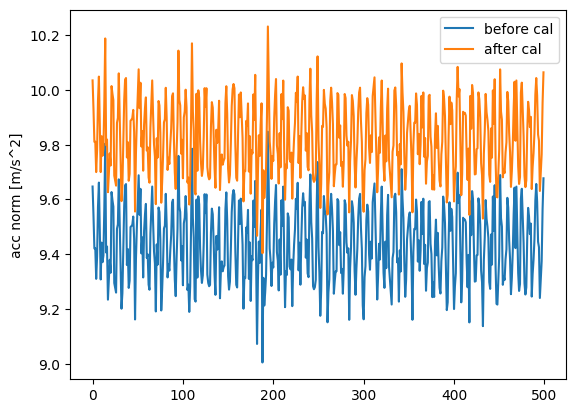

In [15]:
import matplotlib.pyplot as plt
from numpy.linalg import norm

plt.figure()
plt.plot(norm(data.filter(like="acc"), axis=1)[500:1000], label="before cal")
plt.plot(norm(calibrated_data.filter(like="acc")[500:1000], axis=1), label="after cal")
plt.legend()
plt.ylabel("acc norm [m/s^2]")
plt.show()

Finally, remove temp directory.



In [ ]:
d.cleanup()